In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits

/usr/local/lib/python3.6/site-packages/pandas/compat/__init__.py:120: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:
d_model = 64
name = f"pix2pix_2_bs4_ep4_lambda100"
output_dir = f"../output/{name}"

/usr/local/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/usr/local/lib/python3.6/site-packages/matplotlib/axes/_base.py:237: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/usr/local/lib/python3.6/site-packages/matplotlib/axes/_base.py:239: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


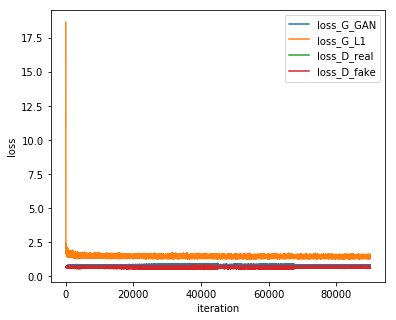

In [3]:
# loss function
fname = f"{output_dir}/loss_log.txt"

df = pd.read_csv(fname, sep=" ", header=0)
header = df.columns

plt.figure(figsize=(6,5))
plt.xlabel("iteration")
plt.ylabel("loss")

epoch = df["#iter"]
key_list = header[4:]
for i, key in enumerate(key_list):
    plt.plot(epoch, df[key], label=key)
plt.legend(loc="upper right")

plt.savefig("loss.png")

<Figure size 864x576 with 0 Axes>

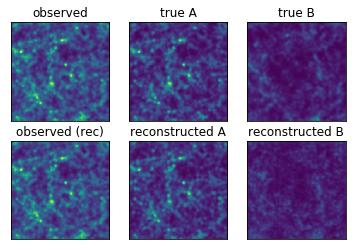

In [23]:
# reproduced map
suffix = f"run0_index0"
f_realA = f"../val_data/{suffix}_z1.3_ha.fits"
f_realB = f"../val_data/{suffix}_z2.0_oiii.fits"
f_fakeA = f"{output_dir}/test/gen_{suffix}_0.fits"
f_fakeB = f"{output_dir}/test/gen_{suffix}_1.fits"

f_list = [ f_realA, f_realB, f_fakeA, f_fakeB ]
data = [ fits.open( f )[0].data for f in f_list ]

label_list = ["observed", "true A", "true B", "observed (rec)", "reconstructed A", "reconstructed B"]
data = [ data[0]+data[1], data[0], data[1], data[2]+data[3], data[2], data[3] ]

vmin = 0
vmax = np.max(data[0])

fig, axs = plt.subplots(2,3)

for i, (d, l) in enumerate(zip(data, label_list)):    
    ax = axs[int(i/3)][int(i%3)]
    ax.tick_params(labelbottom=False, labelleft=False, bottom=False, left=False)
    ax.set_title(l)
    im = ax.imshow(d, interpolation="none", vmin=vmin, vmax=vmax)   
    
plt.savefig("test_image.png")

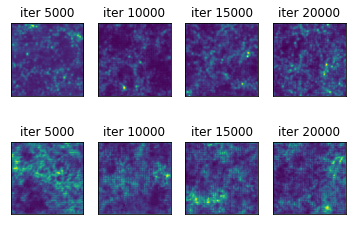

In [3]:
# reproduced map during training
freq = 5000

nmap = 4
iter_list = [ (i+1) * freq for i in range(nmap) ]
nmap = len(iter_list)

fig, axs = plt.subplots(2, nmap)
for i, iter in enumerate(iter_list):
    for j, id in enumerate(["", "_2"]):
        fname = "{}/iter_{:d}{}.fits".format(output_dir, iter, id)
        data = fits.open( fname )[0].data

        ax = axs[j,i]
        ax.tick_params(labelbottom=False, labelleft=False, bottom=False, left=False)
        ax.set_title("iter {:d}".format(iter))
        im = ax.imshow(data, interpolation="none")    

plt.savefig("training_iter.png")

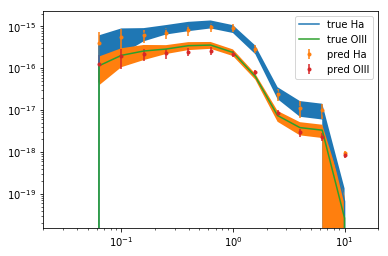

In [11]:
# power spectra
plt.xscale("log")
plt.yscale("log")
plt.xlim([0.02, 20])
labels = [ "Ha", "OIII" ]
snames = [ "z1.3_ha", "z2.0_oiii" ]
for i, sname in enumerate(snames):
    fname = f"../calculation/output/ps_{sname}_{name}.txt"
    data = np.loadtxt(fname)
    k = data[:,0]
    true = data[:,1]
    s_true = data[:,2]
    pred = data[:,3]
    s_pred = data[:,4]
    
    plt.plot(k, true, label=f"true {labels[i]}")
    plt.fill_between(k, true+s_true, true-s_true)
    plt.errorbar(k, pred, s_pred, fmt=".", label=f"pred {labels[i]}")
    
plt.legend()

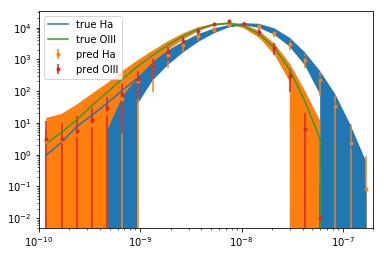

In [28]:
# probability distribution function

plt.xscale("log")
plt.yscale("log")
plt.xlim([1e-10,2e-7])

labels = [ "Ha", "OIII" ]
snames = [ "z1.3_ha", "z2.0_oiii" ]

for i, sname in enumerate(snames):
    fname = f"../calculation/output/pdf_log_{sname}_{name}.txt"
    data = np.loadtxt(fname)
    x = data[:,0]
    true = data[:,1]
    s_true = data[:,2]
    pred = data[:,3]
    s_pred = data[:,4]
    
    plt.plot(x, true, label=f"true {labels[i]}")
    plt.fill_between(x, true+s_true, true-s_true)
    plt.errorbar(x, pred, s_pred, fmt=".", label=f"pred {labels[i]}")
    
plt.legend()

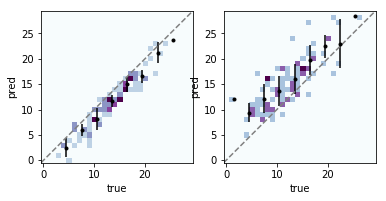

In [24]:
# mean prediction
xmins = [ 0.75, 0.55 ]
xmaxs = [ 1.75, 1.05 ]
fig, axs = plt.subplots(1,2)
for i, sname in enumerate(snames):
    ax = axs[i]

    fname = f"../calculation/output/mean_mesh_{sname}_{name}.txt"
    data = np.loadtxt(fname)
    ax.imshow(data, cmap="BuPu", origin="lower")
    nmesh = len(data)
    
    fname = f"../calculation/output/mean_{sname}_{name}.txt"
    data = np.loadtxt(fname) 
    coef = nmesh / ( xmaxs[i] - xmins[i] )
    x = ( data[:,0] - xmins[i] ) * coef
    y = ( data[:,1] - xmins[i] ) * coef
    e = data[:,2] * coef
    ax.errorbar(x, y, e, fmt=".", color="k")
    
    ax.set_xlim([-0.5,nmesh-0.5])
    ax.set_ylim([-0.5,nmesh-0.5])
    
    ax.set_xlabel("true")
    ax.set_ylabel("pred")
    
    xlim = ax.get_xlim()
    xx = np.linspace(xlim[0],xlim[1],10)
    ax.plot(xx, xx, color="gray", ls="--")